In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm

In [2]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

In [3]:
from Corrfunc.mocks import DDrppi_mocks, DDtheta_mocks
from Corrfunc.io import read_catalog
from Corrfunc.theory import DDrppi, DD
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf

In [4]:
quasar = np.load('../catalogue/quasar_lss_all.npy')
random = np.load('../catalogue/random_quasar_lss_all.npy')
Nd = len(quasar)
Nr = len(random)

In [5]:
dis_cov_q = cosmos.angular_diameter_distance(quasar['z']).to(u.Mpc).value*(1+quasar['z'])*h
dis_cov_r = cosmos.angular_diameter_distance(random['z']).to(u.Mpc).value*(1+random['z'])*h

In [6]:
Nbins = 15
rp_min = 3
rp_max = 100
rp_bin = np.geomspace(rp_min, rp_max, Nbins+1)
r_p = (rp_bin[:-1]*rp_bin[1:])**0.5

z = 1.69
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100
d_A = cosmos.angular_diameter_distance(z).to(u.Mpc).value
chi_l = d_A*(1+z)

theta_bins = rp_bin/h/(1+z)/d_A
theta_bins_deg = np.rad2deg(theta_bins)

pimax = 100

pair counts

In [13]:
dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], is_comoving_dist=True, weight_type='pair_product')
rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=random['ra'], DEC1=random['dec'], CZ1=dis_cov_r, weights1=random['w'], is_comoving_dist=True, weight_type='pair_product')
dr = DDrppi_mocks(
    autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
    RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], 
    RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
    is_comoving_dist=True, weight_type='pair_product')

result of $\xi(r_p, \pi)$

In [18]:
result = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd, dr, dr, rr)

Text(0, 0.5, '$\\log r_p$')

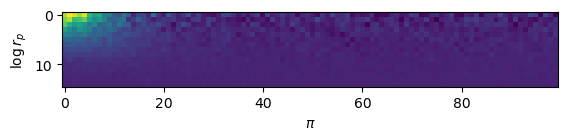

In [19]:
plt.imshow(result.reshape((Nbins, pimax)))
plt.xlabel('$\\pi$')
plt.ylabel('$\\log r_p$')

In [21]:
from scipy.interpolate import RegularGridInterpolator
rp = (rp_bin[1:]*rp_bin[:-1])**0.5
pi = np.arange(pimax)+0.5
func = RegularGridInterpolator((rp, pi), result.reshape((Nbins, pimax)), bounds_error=False, fill_value=None)

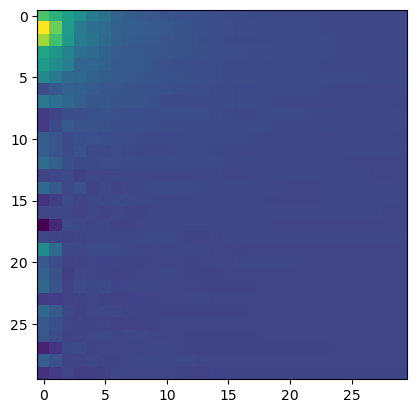

In [23]:
xx = np.linspace(0, 50, 30)+0.5
new_rp, new_pi = np.meshgrid(xx, xx)

plt.imshow(func((new_rp.flatten(), new_pi.flatten())).reshape(new_rp.shape))

result of $w(r_p)$

In [14]:
w = convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

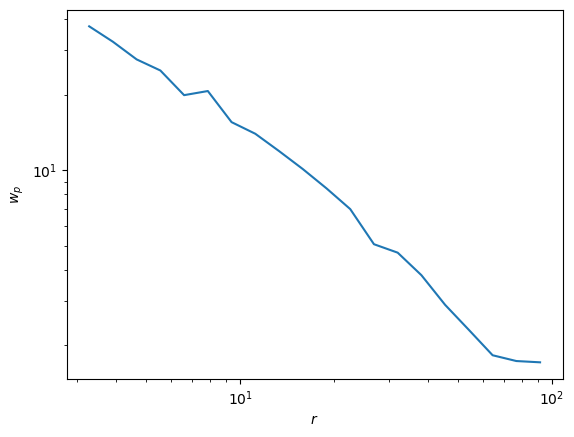

In [16]:
plt.plot(r_p, w)
plt.loglog()
# plt.ylim(1e-1, 1e2)
plt.xlabel('$r$')
plt.ylabel('$w_p$')
plt.show()

In [13]:
z = 0
w_scaled = w * cosmos.Om(z) * cosmos.critical_density(z).to('M_sun/pc^3').value / h**2 * 1e6

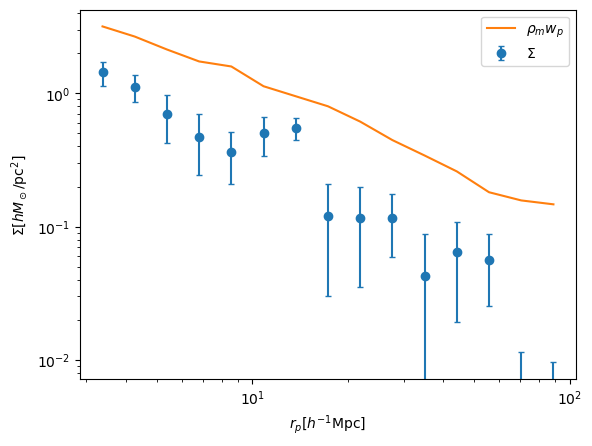

In [14]:
res = np.loadtxt('quasar_lss_sigma_2048')
res_2 = np.loadtxt('quasar_auto')
plt.errorbar(res[:,0], res[:,1], res[:,2], capsize=2, fmt='o', label='$\\Sigma$')
plt.errorbar(res_2[:,0], res_2[:,1], res_2[:,2], capsize=2, fmt='o', label='$\\Sigma$')
plt.plot(r_p, w_scaled, label='$\\rho_m w_p$')
plt.loglog()
plt.xlabel('$r_p[h^{-1}\\mathrm{Mpc}]$')
plt.ylabel('$\\Sigma[h M_\\odot /\\mathrm{pc}^2]$')
plt.legend()
plt.savefig('./fig/auto_vs_cross')

Jackknife

In [7]:
import healpy as hp

In [8]:
Nside_jack = 10

In [10]:
c = coo.SkyCoord(ra=quasar['ra']*u.degree, dec=quasar['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
npix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
c = coo.SkyCoord(ra=random['ra']*u.degree, dec=random['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
npix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

pix = np.unique(npix)

In [8]:
with open('label.bin', 'rb') as f:
    npix = np.load(f)
    npix_r = np.load(f)
pix = np.unique(npix)

In [9]:
def resample(p, sender):
    sub_sample = npix != p
    sub_sample_r = npix_r != p

    quasar_sub = quasar[sub_sample]
    random_sub = random[sub_sample_r]

    dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                    RA1=random_sub['ra'], DEC1=random_sub['dec'], CZ1=dis_cov_r[sub_sample_r], weights1=random_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    dr = DDrppi_mocks(
        autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
        RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], 
        RA2=random_sub['ra'], DEC2=random_sub['dec'], CZ2=dis_cov_r[sub_sample_r], weights2=random_sub['w'], 
        is_comoving_dist=True, weight_type='pair_product')

    Nd = len(quasar_sub)
    Nr = len(random_sub)
    sender.send(1)
    return convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)


In [10]:
def progress_bar(Ntotal, receiver, rate=10):
    # rate is the update rate of the progress bar.
    rate = max(1, int(rate))
    with tqdm(total=int(Ntotal/rate)) as pbar:
        count = 0
        while True:
            if receiver.recv():
                count += 1
                if count % rate == 0:
                    pbar.update(1)
            else:
                break
        pbar.close()

In [11]:
from itertools import repeat

In [12]:
sender, recv = mp.Pipe()

pool = mp.Pool(5)

bar = mp.Process(target=progress_bar, args=(len(pix), recv, 1))
bar.start()
w_arr = np.vstack(list(tqdm(pool.starmap(resample, zip(pix, repeat(sender))))))
sender.send(0)
bar.join()

100%|██████████| 100/100 [10:19<00:00,  6.20s/it]t/s]



In [13]:
np.save('auto_corr_jackknife_kmeans_100', w_arr)

In [5]:
w_arr = np.load('auto_corr_jackknife_kmeans_100.npy')

In [6]:
val = w_arr.mean(axis=0)
std = w_arr.std(axis=0, ddof=0) * np.sqrt(w_arr.shape[0] - 1)

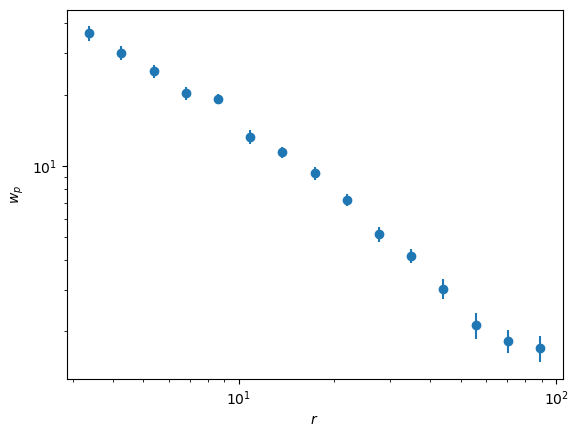

In [8]:
Nbins = 15
rp_min = 3
rp_max = 100
rp_bin = np.geomspace(rp_min, rp_max, Nbins+1)
r_p = (rp_bin[:-1]*rp_bin[1:])**0.5
plt.errorbar(r_p, val, std, fmt='o')
plt.loglog()
# plt.ylim(1e-1, 1e2)
plt.xlabel('$r$')
plt.ylabel('$w_p$')
plt.show()

In [10]:
scale = cosmos.Om(0) * cosmos.critical_density(0).to('M_sun/pc^3').value / h**2 * 1e6

In [12]:
scale

0.08594199199294394

In [14]:
w_scaled = val*scale
std_scaled = std*scale

In [15]:
np.savetxt('quasar_auto_corr', np.c_[r_p, w_scaled, std_scaled])

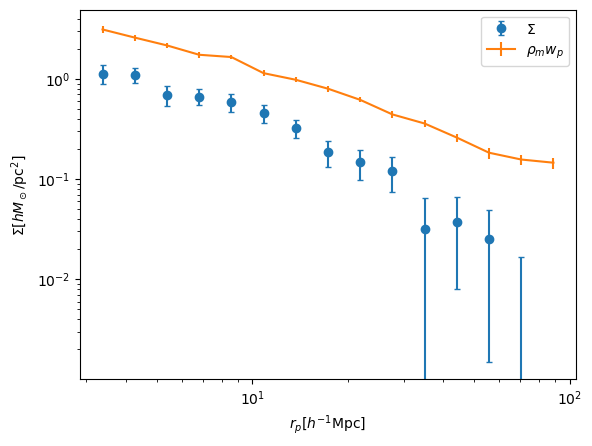

In [16]:
res = np.loadtxt('./results/quasar_lss_all_cmb_smoothed_6')
plt.errorbar(res[:,0], res[:,1], res[:,2], capsize=2, fmt='o', label='$\\Sigma$')
plt.errorbar(r_p, w_scaled, std_scaled, label='$\\rho_m w_p$')
plt.loglog()
plt.xlabel('$r_p[h^{-1}\\mathrm{Mpc}]$')
plt.ylabel('$\\Sigma[h M_\\odot /\\mathrm{pc}^2]$')
plt.legend()

result of $w(\theta)$

In [20]:
dd_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg,
                         RA1=quasar['ra'], DEC1=quasar['dec'], weights1=quasar['w'])
dr_theta = DDtheta_mocks(autocorr=0, nthreads=50, binfile=theta_bins_deg, 
                         RA1=quasar['ra'], DEC1=quasar['dec'], weights1=quasar['w'],
                         RA2=random['ra'], DEC2=random['dec'], weights2=random['w'])
rr_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg, 
                         RA1=random['ra'], DEC1=random['dec'], weights1=random['w'])

In [21]:
w_theta = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd_theta, dr_theta, dr_theta, rr_theta)

<function matplotlib.pyplot.show(close=None, block=None)>

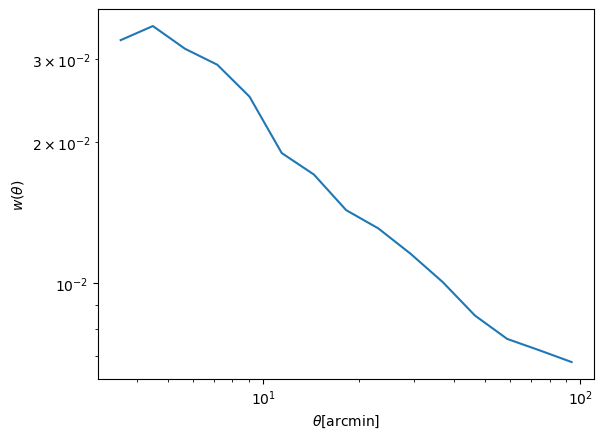

In [22]:
plt.plot((theta_bins_deg[1:]*theta_bins_deg[:-1])**0.5*60, w_theta)
plt.loglog()
plt.xlabel('$\\theta[\\mathrm{arcmin}]$')
plt.ylabel('$w(\\theta)$')
plt.show()